source for the jascscript code below: https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython

In [1]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from sklearn.metrics import mean_squared_error as mse, r2_score
from IPython.display import display, Markdown

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller  

In [3]:
def best_ARIMA(ticker, start_date, end_date, p_values, d_values, q_values, feature='Adj Close', test_size=0.9, lag_number=52, adf_alpha=0.01):
    
    # reading in closing stock info
    stock = yf.download(ticker, start=start_date, end=end_date)

    df = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date))
    df = stock[feature]
    df.dropna(inplace=True)
    
    # train test split
    split_index = round(len(df) * test_size)
    train_end_date = df.iloc[[split_index - 1]].index[0].strftime('%m-%d-%Y')
    test_start_date = df.iloc[[split_index ]].index[0].strftime('%m-%d-%Y')
    
    train = df[:split_index]
    test = df[split_index:]
    
    
    # Starting values for AIC and ARIMA order
    best_aic = 1e20 # arbitrarily large value
    best_p = 0
    best_q = 0
    best_d = 0
    
    print(f'Testing {len(p_values) * len(d_values) * len(q_values)} different ARIMA models...')
    for p in p_values:
        for d in d_values:
            for q in q_values:
                #print(f'Checking AIC improvement in ARIMA({p},{d},{q})')
                # ^ uncomment if you want to see each iteration as it happens
                try:
                    model = ARIMA(train, order=(p,d,q)).fit()


                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_p = p
                        best_d = d
                        best_q = q
                        
                        '''
                        This section can be uncommented if you want to see
                        which ARIMA models improve the AIC score and
                        by how much.
                        
                        print(f'ARIMA({p},{d},{q})')
                        print(f'AIC: {best_aic}')
                        print(f'Training RMSE: {rmse(train[d:], train_preds, squared=False):.3e}')
                        print(f'Testing RMSE: {rmse(test, test_preds, squared=False):.3e}')
                        print()
                        '''

                except np.linalg.LinAlgError:
                    print(f'LinAlgError: SVD in ARIMA({p},{d},{q}) does not converge.')

                except ValueError:
                    print(f'ValueError: The computed initial AR coefficients are not stationary for ARIMA({p},{d},{q})')

    # after all p, d, and q value combinations are iterated over                
    print('##################################################')
    print('Modelling completed')
    train_preds = model.predict(train.index[d], train.index[-1])
    test_preds = model.forecast(steps=len(test))
    residuals = test.values - test_preds.values
    
    display(Markdown(f'Lowest AIC Model:'))
    display(Markdown(f'ARIMA({best_p},{best_d},{best_q})'))
    display(Markdown(f'AIC: {best_aic}'))
    print()
    display(Markdown(f'Training MSE: {mse(train[d:], train_preds):.3e}'))
    display(Markdown(f'Testing MSE: {mse(test, test_preds):.3e}'))
    print()
    display(Markdown(f'Training RMSE: {mse(train[d:], train_preds, squared=False):.3e}'))
    display(Markdown(f'Testing RMSE: {mse(test, test_preds, squared=False):.3e}'))
    print()
    display(Markdown(f'Training $R^2$: {r2_score(train[d:], train_preds):.3e}'))
    display(Markdown(f'Testing $R^2$: {r2_score(test, test_preds):.3e}'))
    print()
    

    # show ACF and PACF plots
    if lag_number >= len(df):
        print(f'Error: lag number too large. Max lag amount of {len(df) - 1} used instead')
        plot_acf(df, lags=len(df) - 1)
        plt.title(f'Autocorrelation of {ticker} with {lag_number} lags')
        plot_pacf(df, lags=len(df) - 1)
        plt.title(f'Partial Autocorrelation of {ticker} with {lag_number} lags')
        print()
    else:
        plot_acf(df, lags=lag_number)
        plt.title(f'Autocorrelation of {ticker} with {lag_number} lags')
        plot_pacf(df, lags=lag_number)
        plt.title(f'Partial Autocorrelation of {ticker} with {lag_number} lags')
        print()
        
    # show results of the Augmented Dickey-Fuller test for stationarity
    test_results = pd.Series(adfuller(df.dropna())[0:2], index=['Test Statistic','p-value'])
    if test_results[1] <= adf_alpha:
        display(Markdown('Augmented Dickey-Fuller test results:'))
        print(test_results)
        display(Markdown(f'With an $\\alpha$ level of {adf_alpha} amd a $p$-value of {test_results}, we reject the null hypothesis and assume that the data is stationary.'))
    else:
        print('Augmented Dickey-Fuller test results:')
        print(test_results)
        display(Markdown(f'With an $\\alpha$ level of {adf_alpha} amd a $p$-value of {test_results}, we fail to reject the null hypothesis and assume that the data is not stationary.'))
   
    # showing a graph of our forecast vs the actual values
    plt.figure(figsize=(16,8))
    plt.plot(train.index, train, color='blue', label=f'Train, {start_date} to {train_end_date}')
    plt.plot(test.index, test, color='orange', label=f'Test, {test_start_date} to {end_date}')
    plt.plot(test.index, test_preds, color='green', label=f'Forecasted Test Values using ARIMA({best_p}, {best_d}, {best_q})')

    plt.title(f'{ticker} stock from {start_date} to {end_date}', size=16)
    plt.xlabel('Date', size=16)
    plt.ylabel('Feature', size=16)
    plt.legend(fontsize=12)
    plt.show();
    
    # zooming in on just the test forecast and actual values
    plt.figure(figsize=(16,8))
    plt.plot(test.index, test, color='orange', label=f'Test, {test_start_date} to {end_date}')
    plt.plot(test.index, test_preds, color='green', label=f'Forecasted Test Values using ARIMA({best_p}, {best_d}, {best_q})')
    plt.title(f'{ticker} Forecast Vs. Actual from {test_start_date} to {end_date}', size=16)
    plt.xlabel('Date', size=16)
    plt.ylabel(f'{feature}', size=16)
    plt.legend(fontsize=12)
    plt.show();
    
    #plot residuals of test values
    plt.figure(figsize=(16,8))
    plt.title(f'Residuals of ARIMA model of order ({best_p}, {best_d}, {best_q}) on {ticker} prices', size=16)
    plt.xlabel('Date', size=16)
    plt.ylabel('Residuals', size=16)
    plt.plot(test.index, residuals, color='r')
    plt.axhline(y=0, color='grey', linestyle='dashed')
    plt.fill_between(test.index, residuals, 0, color='r', alpha=0.25)
    plt.show();
    
    return

[*********************100%***********************]  1 of 1 completed
Testing 108 different ARIMA models...


/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_m

/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_m

/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_m

/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace

/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_m

/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_m

/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, b

/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_m

/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:

/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_m

/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, b

/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, b

/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_m

##################################################
Modelling completed


/Users/maitiusexton/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Lowest AIC Model:

ARIMA(5,1,4)

AIC: 11455.995335706286

Training MSE: 2.703e+02

Testing MSE: 2.307e+04

Training RMSE: 1.644e+01

Testing RMSE: 1.519e+02

Training $R^2$: 9.957e-01

Testing $R^2$: -4.056e-01



Augmented Dickey-Fuller test results:
Test Statistic   -0.404273
p-value           0.909383
dtype: float64


With an $\alpha$ level of 0.01 amd a $p$-value of Test Statistic   -0.404273
p-value           0.909383
dtype: float64, we fail to reject the null hypothesis and assume that the data is not stationary.

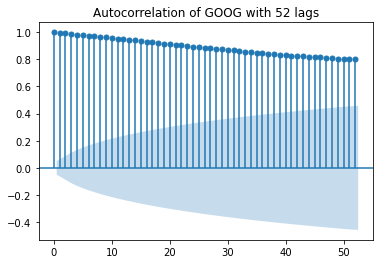

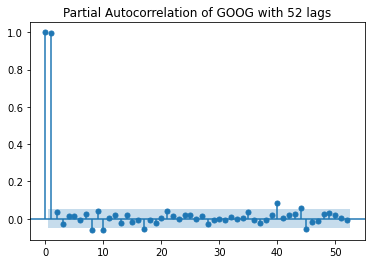

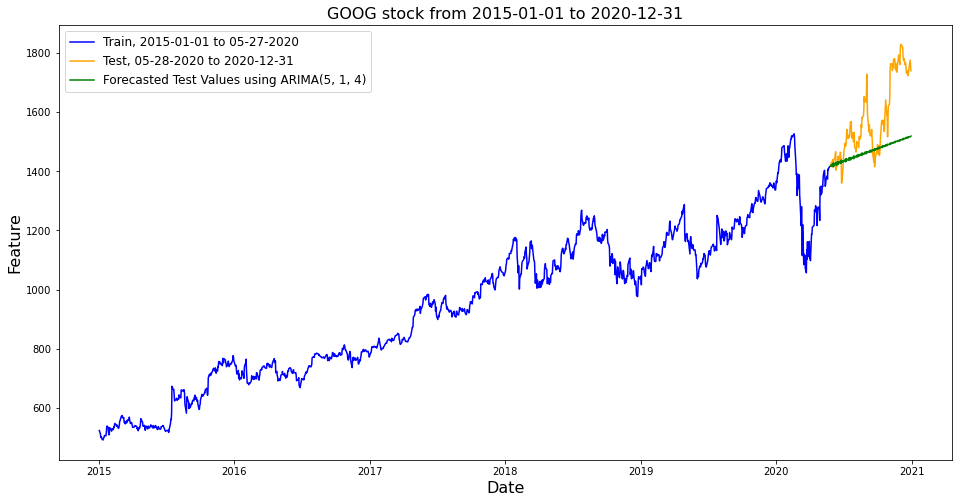

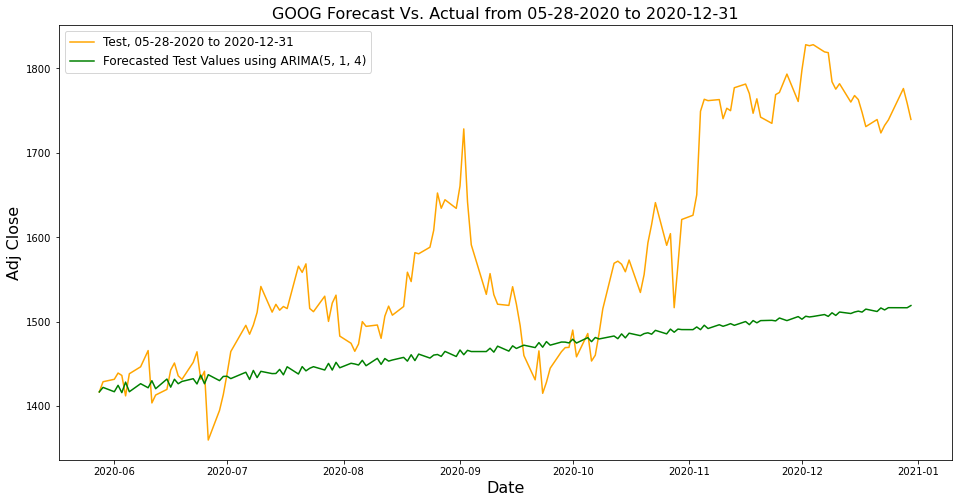

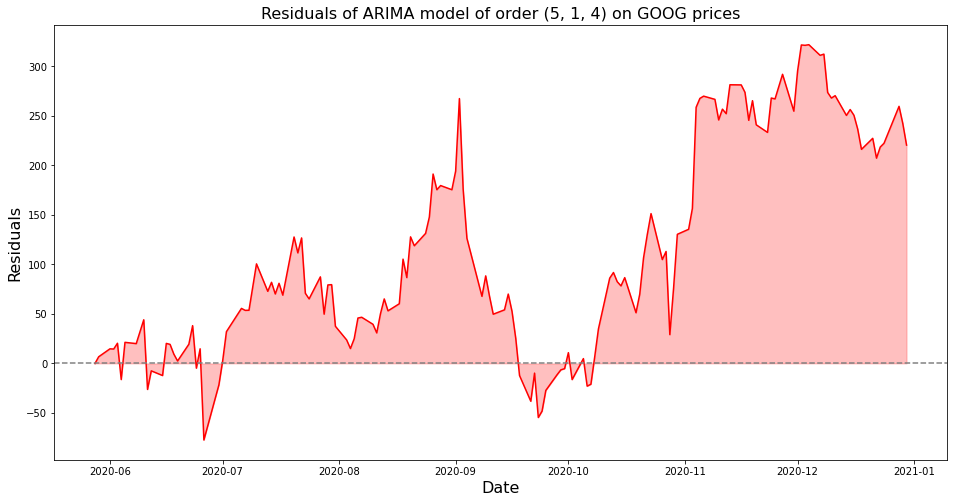

CPU times: user 2min 57s, sys: 3.71 s, total: 3min 1s
Wall time: 3min 47s


In [4]:
%%time
p = range(6)
d = range(3)
q = range(6)

best_ARIMA('GOOG', '2015-01-01', '2020-12-31', p, d, q)